In [32]:
# import torch
import numpy as np
import iceberg as ice
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from functools import partial

In [4]:
def logpdf(x):
    r = jnp.linalg.norm(x, axis=-1)
    return -(r - 2.6)**2 / 0.033

grad_logpdf = jax.grad(logpdf)

# `grad_logpdf` takes in a single 2D point. We want to be able to
# pass in multiple 2D points for higher throughput.
multi_grad_logpdf = jax.vmap(grad_logpdf, in_axes=(0,))

@partial(jax.jit, static_argnums=(0,))
def langevin_update(grad_func, current_particles, key, epsilon=1e-2):
    key, subkey = jax.random.split(key)
    noise = jax.random.normal(subkey, current_particles.shape)
    next_particles = (
        current_particles
        + epsilon * grad_func(current_particles)
        + jnp.sqrt(2 * epsilon) * noise
    )
    return next_particles, key


def sample_langevin(grad_func, key, num_steps=1000, num_particles=1000, epsilon=1e-2):
    key, subkey = jax.random.split(key)
    particles = jax.random.normal(subkey, (num_particles, 2))

    for t in range(num_steps):
        particles, key = langevin_update(
            grad_func, particles, key, epsilon=epsilon)

    return particles

key = jax.random.PRNGKey(0)
data = sample_langevin(multi_grad_logpdf, key, num_steps=1000, num_particles=10000)
data = np.array(data)

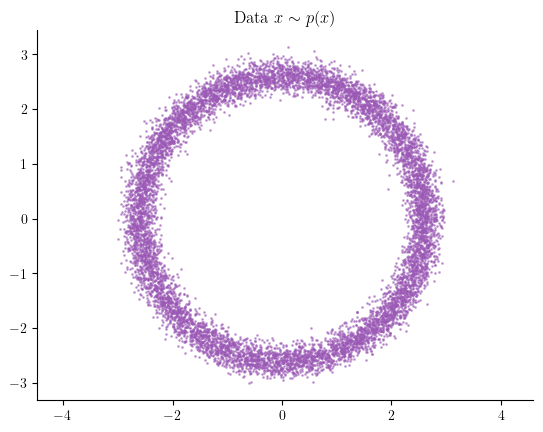

In [21]:
# Plot the data
plt.rcParams["text.usetex"] = True
font = {"family": "serif", "serif": ["computer modern roman"]}
plt.rc("font", **font)

plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5, c="#9b59b6")
plt.axis("equal")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.title("Data $x \sim p(x)$")

# Latex font for number labels on axes
plt.savefig("../../../../static/img/density/data.svg")
plt.show()

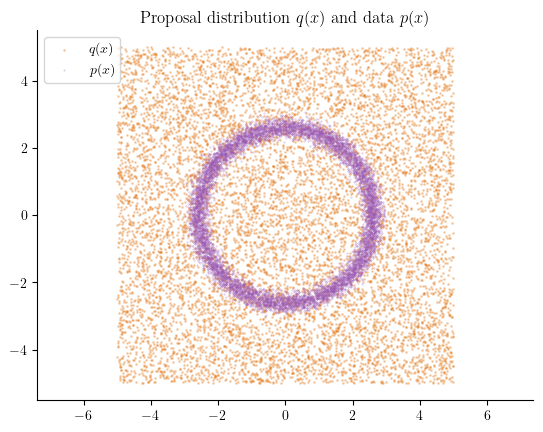

In [60]:
# Proposal distribution is a 2D uniform between -5 and 5
proposal_dataset = np.random.uniform(-5, 5, (10000, 2))

# Plot the proposal distribution
plt.scatter(proposal_dataset[:, 0], proposal_dataset[:, 1], s=1, alpha=0.3, c="#e67e22", label="$q(x)$")

# Plot the data on top
plt.scatter(data[:, 0], data[:, 1], s=0.1, alpha=0.5, c="#9b59b6", label="$p(x)$")

plt.legend()

plt.axis("equal")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.title("Proposal distribution $q(x)$ and data $p(x)$")

plt.savefig("../../../../static/img/density/proposal.svg")

plt.show()

In [37]:
batch_size = 128
num_steps = 10000

class DensityModel(nn.Module):
    def __init__(self):
        super(DensityModel, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


def sample_batch():
    data_idx = np.random.choice(len(data), batch_size // 2)
    proposal_idx = np.random.choice(len(proposal_dataset), batch_size // 2)

    data_batch = torch.tensor(data[data_idx], dtype=torch.float32)
    proposal_batch = torch.tensor(proposal_dataset[proposal_idx], dtype=torch.float32)

    return torch.cat([data_batch, proposal_batch], dim=0)

def loss_fn(model, x):
    ratios = torch.exp(model(x))
    ratios_p = ratios[:batch_size // 2]
    ratios_q = ratios[batch_size // 2:]
    return torch.mean(-torch.log(ratios_p / (ratios_p + 1)) - torch.log(1 / (ratios_q + 1)))

model = DensityModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for step in range(num_steps):
    optimizer.zero_grad()
    x = sample_batch()
    loss = loss_fn(model, x)
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, loss: {loss.item()}")

Step 0, loss: 1.3990192413330078
Step 100, loss: 0.7969473004341125
Step 200, loss: 0.5623870491981506
Step 300, loss: 0.48045042157173157
Step 400, loss: 0.46917086839675903
Step 500, loss: 0.3491682708263397
Step 600, loss: 0.49743250012397766
Step 700, loss: 0.33439040184020996
Step 800, loss: 0.4771822690963745
Step 900, loss: 0.4219350218772888
Step 1000, loss: 0.3302539587020874
Step 1100, loss: 0.3498680889606476
Step 1200, loss: 0.5170326232910156
Step 1300, loss: 0.4151751399040222
Step 1400, loss: 0.2603234052658081
Step 1500, loss: 0.46888867020606995
Step 1600, loss: 0.43308234214782715
Step 1700, loss: 0.43484437465667725
Step 1800, loss: 0.5351740717887878
Step 1900, loss: 0.35941848158836365
Step 2000, loss: 0.4215545654296875
Step 2100, loss: 0.4561663866043091
Step 2200, loss: 0.4361181855201721
Step 2300, loss: 0.3448196351528168
Step 2400, loss: 0.3608818054199219
Step 2500, loss: 0.4221225082874298
Step 2600, loss: 0.3569350838661194
Step 2700, loss: 0.2318651527166

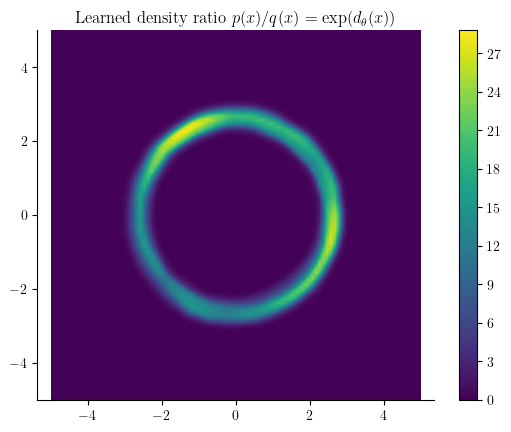

In [44]:
def model_fn(x):
    return torch.exp(model(x))

# Plot learned ration from -5 to 5.
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(100):
    for j in range(100):
        Z[i, j] = model_fn(torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float32)).item()

plt.contourf(X, Y, Z, levels=100, cmap="viridis")
plt.colorbar()
plt.axis("equal")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.title("Learned density ratio $p(x)/q(x) = \\exp(d_\\theta(x))$")
plt.savefig("../../../../static/img/density/learned.png", dpi=300)
plt.show()

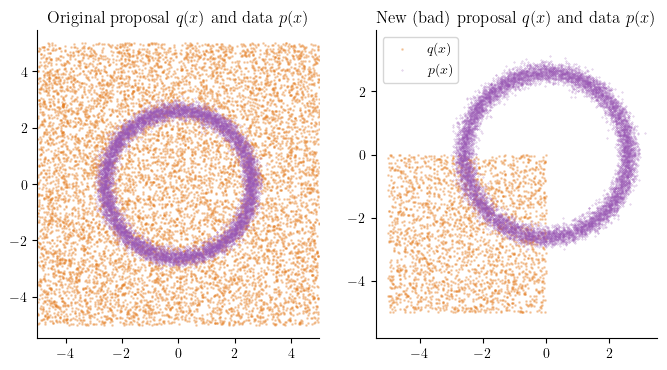

In [63]:
# Proposal distribution is a 2D uniform between -5 and 5
original_proposal = np.random.uniform(-5, 5, (10000, 2))
proposal_dataset = np.random.uniform(-5, 0, (10000//4, 2))

# # Plot the proposal distribution
# plt.scatter(original_proposal[:, 0], original_proposal[:, 1], s=1, alpha=0.3, c="#e67e22", label="$q(x)$")

# # Plot the data on top
# plt.scatter(data[:, 0], data[:, 1], s=0.1, alpha=0.5, c="#9b59b6", label="$p(x)$")

# plt.legend()

# plt.axis("equal")
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.title("Proposal distribution $q(x)$ and data $p(x)$")

# plt.savefig("../../../../static/img/density/proposal.svg")

# plt.show()

# Plot the original proposal distribution and proposal dataset in two side-by-side plots.
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].scatter(original_proposal[:, 0], original_proposal[:, 1], s=1, alpha=0.3, c="#e67e22", label="$q(x)$")
axs[0].scatter(data[:, 0], data[:, 1], s=0.1, alpha=0.5, c="#9b59b6", label="$p(x)$")
axs[0].axis("equal")
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].set_xbound(-5, 5)
axs[0].set_ybound(-5, 5)
axs[0].set_title("Original proposal $q(x)$ and data $p(x)$")

axs[1].scatter(proposal_dataset[:, 0], proposal_dataset[:, 1], s=1, alpha=0.3, c="#e67e22", label="$q(x)$")
axs[1].scatter(data[:, 0], data[:, 1], s=0.1, alpha=0.5, c="#9b59b6", label="$p(x)$")
axs[0].set_xbound(-5, 5)
axs[0].set_ybound(-5, 5)
axs[1].axis("equal")
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].set_title("New (bad) proposal $q(x)$ and data $p(x)$")

plt.legend()

plt.savefig("../../../../static/img/density/new_proposal.svg")

plt.show()

In [65]:
batch_size = 128
num_steps = 2000

class DensityModel(nn.Module):
    def __init__(self):
        super(DensityModel, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


def sample_batch():
    data_idx = np.random.choice(len(data), batch_size // 2)
    proposal_idx = np.random.choice(len(proposal_dataset), batch_size // 2)

    data_batch = torch.tensor(data[data_idx], dtype=torch.float32)
    proposal_batch = torch.tensor(proposal_dataset[proposal_idx], dtype=torch.float32)

    return torch.cat([data_batch, proposal_batch], dim=0)

def loss_fn(model, x):
    ratios = torch.exp(model(x))
    ratios_p = ratios[:batch_size // 2]
    ratios_q = ratios[batch_size // 2:]
    return torch.mean(-torch.log(ratios_p / (ratios_p + 1)) - torch.log(1 / (ratios_q + 1)))

model = DensityModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for step in range(num_steps):
    optimizer.zero_grad()
    x = sample_batch()
    loss = loss_fn(model, x)
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, loss: {loss.item()}")

Step 0, loss: 1.2952330112457275
Step 100, loss: 0.6578508019447327
Step 200, loss: 0.5400354266166687
Step 300, loss: 0.30017274618148804
Step 400, loss: 0.3301384449005127
Step 500, loss: 0.31793928146362305
Step 600, loss: 0.3297228217124939
Step 700, loss: 0.2582014501094818
Step 800, loss: 0.23613479733467102
Step 900, loss: 0.2819068729877472
Step 1000, loss: 0.16870826482772827
Step 1100, loss: 0.236587792634964
Step 1200, loss: 0.2111116349697113
Step 1300, loss: 0.2838941514492035
Step 1400, loss: 0.1868358850479126
Step 1500, loss: 0.23878619074821472
Step 1600, loss: 0.26624688506126404
Step 1700, loss: 0.2993474006652832
Step 1800, loss: 0.48271849751472473
Step 1900, loss: 0.17218497395515442


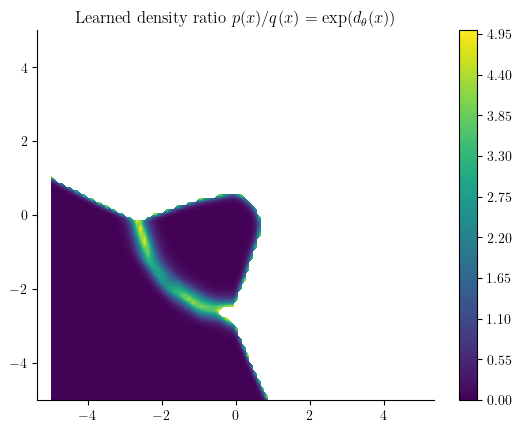

In [70]:
def model_fn(x):
    return torch.exp(model(x))

# Plot learned ration from -5 to 5.
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(100):
    for j in range(100):
        Z[i, j] = model_fn(torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float32)).item()

# Z = np.clip(Z, 0, 5)
# Replace anything > 5 with nan.
Z[Z > 5] = np.nan

plt.contourf(X, Y, Z, levels=100, cmap="viridis")
plt.colorbar()
plt.axis("equal")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.title("Learned density ratio $p(x)/q(x) = \\exp(d_\\theta(x))$")
plt.savefig("../../../../static/img/density/learned_bad.png", dpi=300)
plt.show()

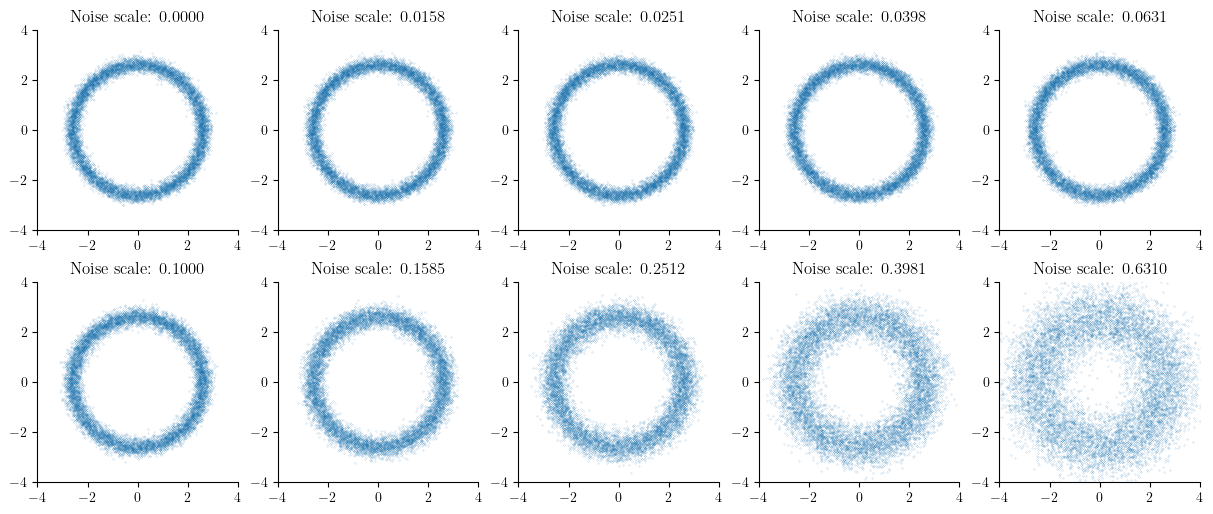

In [79]:
NUM_NOISE_SCALES = 10
NOISE_SCALES = [0.63096**scale_index for scale_index in range(NUM_NOISE_SCALES)][::-1]
FULL_NOISE_SCALES = np.array([0] + NOISE_SCALES)

# for noise_scale in FULL_NOISE_SCALES:
#     noised = data + np.random.normal(0, noise_scale, data.shape)

#     plt.scatter(noised[:, 0], noised[:, 1], s=0.01)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.xlim(-6, 6)
#     plt.ylim(-6, 6)

#     plt.title(f"Noise scale: {noise_scale:.4f}")

#     plt.show()

# Show these in a grid of 2 rows and 5 columns.
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, noise_scale in enumerate(FULL_NOISE_SCALES[:-1]):
    noised = data + np.random.normal(0, noise_scale, data.shape)

    ax = axs[i // 5, i % 5]
    ax.scatter(noised[:, 0], noised[:, 1], s=0.01)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

    # Remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_title(f"Noise scale: {noise_scale:.4f}")

plt.savefig("../../../../static/img/density/noise_levels.svg")
plt.show()

Step 0, loss: 1.3930082321166992
Step 100, loss: 1.3865636587142944
Step 200, loss: 1.39590322971344
Step 300, loss: 1.3727699518203735
Step 400, loss: 1.3900893926620483
Step 500, loss: 1.3817670345306396
Step 600, loss: 1.3747782707214355
Step 700, loss: 1.3966909646987915
Step 800, loss: 1.3819385766983032
Step 900, loss: 1.3881416320800781
Step 1000, loss: 1.3900343179702759
Step 1100, loss: 1.386920690536499
Step 1200, loss: 1.383054494857788
Step 1300, loss: 1.399969220161438
Step 1400, loss: 1.3778892755508423
Step 1500, loss: 1.3996442556381226
Step 1600, loss: 1.3762863874435425
Step 1700, loss: 1.3524754047393799
Step 1800, loss: 1.3588701486587524
Step 1900, loss: 1.3658145666122437
Step 2000, loss: 1.3562942743301392
Step 2100, loss: 1.393312692642212
Step 2200, loss: 1.3499386310577393
Step 2300, loss: 1.3380707502365112
Step 2400, loss: 1.37252676486969
Step 2500, loss: 1.357387661933899
Step 2600, loss: 1.360543131828308
Step 2700, loss: 1.3854923248291016
Step 2800, los

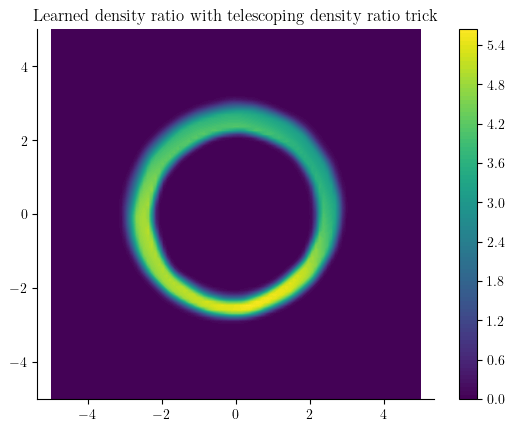

In [108]:
batch_size = 128
num_steps = 20000

class DensityModel(nn.Module):
    def __init__(self):
        super(DensityModel, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x, sigmas):
        # x.shape = (batch_size, 2)
        # sigmas.shape = (batch_size, 1)
        # Concatenate the sigmas to the input to get a (batch_size, 3) tensor.
        x = torch.cat([x, sigmas], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


def sample_batch():
    noise_levels = np.random.randint(0, NUM_NOISE_SCALES, batch_size // 2)

    pre_sigmas = FULL_NOISE_SCALES[noise_levels]
    post_sigmas = FULL_NOISE_SCALES[noise_levels + 1]
    
    data_idx_pre = np.random.choice(len(data), batch_size // 2)
    data_batch_pre = data[data_idx_pre]

    data_idx_post = np.random.choice(len(data), batch_size // 2)
    data_batch_post = data[data_idx_post]

    pre_data = data_batch_pre + np.random.normal(0, pre_sigmas[:, None], data_batch_pre.shape)
    post_data = data_batch_post + np.random.normal(0, post_sigmas[:, None], data_batch_post.shape)

    data_batch = np.concatenate([pre_data, post_data], axis=0)
    sigmas = np.concatenate([post_sigmas, post_sigmas], axis=0)
    return torch.tensor(data_batch, dtype=torch.float32), torch.tensor(sigmas, dtype=torch.float32)[:, None]


def loss_fn(model, x, sigmas):
    ratios = torch.exp(model(x, sigmas))
    ratios_p = ratios[:batch_size // 2]
    ratios_q = ratios[batch_size // 2:]
    return torch.mean(-torch.log(ratios_p / (ratios_p + 1)) - torch.log(1 / (ratios_q + 1)))

model = DensityModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def model_fn(x):
    with torch.inference_mode():
        # Assume x.shape = (2,)
        sigmas = FULL_NOISE_SCALES[1:]
        x = torch.tensor([x for _ in sigmas], dtype=torch.float32)
        sigmas = torch.tensor(sigmas, dtype=torch.float32)[:, None]
        return torch.exp(torch.sum(model(x, sigmas)))

def plot_current_model():
    # Plot learned ration from -5 to 5.
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(100):
        for j in range(100):
            Z[i, j] = model_fn(np.array([X[i, j], Y[i, j]])).item()

    Z[Z > 20] = np.nan

    plt.clf()
    plt.contourf(X, Y, Z, levels=100, cmap="viridis")
    plt.colorbar()
    plt.axis("equal")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.title("Learned density ratio with telescoping density ratio trick")

    return ice.MatplotlibFigure(figure=plt.gcf(), use_svg=False)

scenes = []

for step in range(num_steps):
    optimizer.zero_grad()
    x, sigmas = sample_batch()
    loss = loss_fn(model, x, sigmas)
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, loss: {loss.item()}")

    if step % 1000 == 0:
        scenes.append(plot_current_model())

100%|██████████| 75/75 [00:01<00:00, 41.99it/s]



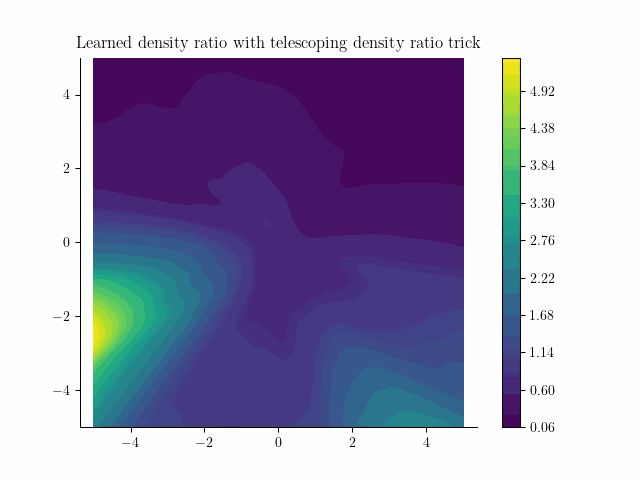

In [113]:
time_per_scene = 0.1

def make_frame(t):
    scene_index = int(t // time_per_scene)
    return scenes[scene_index]

animation = ice.Scene(len(scenes) * time_per_scene, make_frame=make_frame)
animation = animation + animation.freeze(1)
animation.ipython_display(display_format="gif", fps=10)

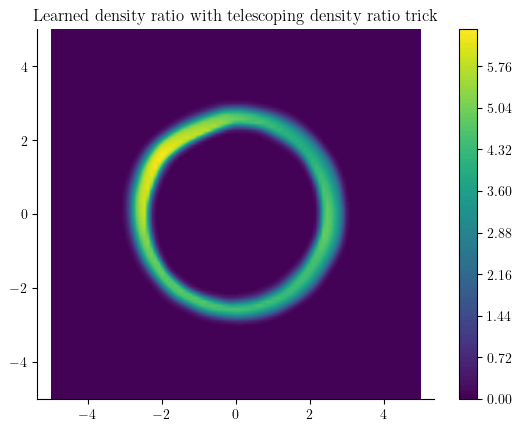

In [102]:
def model_fn(x):
    with torch.inference_mode():
        # Assume x.shape = (2,)
        sigmas = FULL_NOISE_SCALES[1:]
        x = torch.tensor([x for _ in sigmas], dtype=torch.float32)
        sigmas = torch.tensor(sigmas, dtype=torch.float32)[:, None]
        return torch.exp(torch.sum(model(x, sigmas)))

# Plot learned ration from -5 to 5.
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(100):
    for j in range(100):
        Z[i, j] = model_fn(np.array([X[i, j], Y[i, j]])).item()

plt.contourf(X, Y, Z, levels=100, cmap="viridis")
plt.colorbar()
plt.axis("equal")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.title("Learned density ratio with telescoping density ratio trick")
plt.savefig("../../../../static/img/density/learned_tre.png", dpi=300)
plt.show()